# Tensorized grids

Equispaced tensorized grids for Fourier spectral and finite differences methods are implemented in the module 

* `expsolve.discretize.tensorgrid`, which we will import as `ex`

In this notebook we will learn how to

* create 1D, 2D, 3D grids (`grid1d`, `grid`),
* discretize a function on the grid, and
* visualize a function (`plot`, `imshow`).

[Back to tensorgrid quick introduction](00_quick_introduction.ipynb). 

*&#169; Copyright 2019-2023 Pranav Singh*

Use of this source code is governed by the MIT license that can be found in the LICENSE file.

In [18]:
import time 

import numpy as np

import matplotlib.pyplot as plt

import expsolve as es
import expsolve.discretize.tensorgrid as ex

import torch
from torch import exp, sin, cos, abs, real, imag, pi, max, diag
from torch.linalg import norm, matrix_exp

## Creating a 1D grid

The first step in solving a PDE using `expsolve` is to create a grid to discretise our initial functions. These are the grid points on which the numerical solution is computed.

A 1-dimensional grid over the spatial domain `[-1,1]` can be created with the `grid1d` function. 

```Python
    x = grid1d(n)
```
where `n` is the number of grid points.


In [2]:
x = ex.grid1d(10)

Let us check the properties of the grid

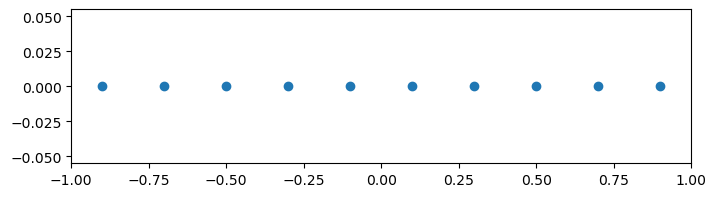

tensor([[-0.9000, -0.7000, -0.5000, -0.3000, -0.1000,  0.1000,  0.3000,  0.5000,
          0.7000,  0.9000]], dtype=torch.float64)
torch.Size([1, 10])
torch.float64


In [3]:
plt.figure(figsize=(8,2))
plt.scatter(x, torch.zeros(x.shape))
plt.xlim(-1, 1)
plt.show()

print(x)
print(x.shape)
print(x.dtype)

A few points to note:

* By default grids are created as `torch.tensor` objects with `double` (i.e. `float64`) accuracy. This makes any function computed on these grids a `torch.tensor` with `float64` accuracy (or `complex128` if the function is complex-valued). This accuracy can be changed by specifying the parameter `dtype`.

* Even a 1D grid is created as a tensor of dimensions `1 x n` where `n` is the number of grid points. This allows `expsolve` to parallelize computations in many applications (such as parameter sweep, optimization and machine learning). This is illustrated with examples in the notebooks `[FIX] BATCH PROCESSING`.

* In the `tensorgrid` module we always assume periodic boundary conditions, and thus at most one of $x=-1$ or $x=1$ should be kept. We take a symmetric approach, i.e. the grids created are symmetric around $x=0$. Thus neither $x=\pm1$ is included, and the origin $x=0$ is only included in a grid with an odd number of points.

If a grid over a different spatial domain `xrange` is sought, we can use the following syntax:

```Python
    x = grid1d(n, xrange)
```
where `n` is the number of grid points and `xrange` is a list of two elements, e.g. `[a,b]` where `a` is the left boundary and `b` the right boundary of the periodic domain. 

Once again, keep in mind that these periodic grids are symmetric and neither end point (`a` or `b`) is included among the grid points. This is in contrast to other periodic grids which may include the rightmost point (`b`) and exclude the leftmost point (`a`), for instance.

**NOTE:** The default value of `xrange` is `[-1,1]` in **all** functions in `expsolve`. 

In [4]:
xrange=[2, 5]
x = ex.grid1d(15, xrange)
print(x)
print(x.shape)

tensor([[2.1000, 2.3000, 2.5000, 2.7000, 2.9000, 3.1000, 3.3000, 3.5000, 3.7000,
         3.9000, 4.1000, 4.3000, 4.5000, 4.7000, 4.9000]], dtype=torch.float64)
torch.Size([1, 15])


We can create grids with different precision by specifying the optional `dtype` parameter.

In [5]:
x64 = ex.grid1d(15)
x32 = ex.grid1d(15, dtype=torch.float32)
x16 = ex.grid1d(15, dtype=torch.float16)

print(x64.dtype)
print(x32.dtype)
print(x16.dtype)

torch.float64
torch.float32
torch.float16


## Sampling a function



Sampling a function on a grid is pretty simple: just call the function on the grid you have created.

* `expsolve` is based on PyTorch and all functions used need to be `torch` based rather than `numpy based`.

* You can perform all torch operations on the grid or the functions as usual.

* The behaviour of `dtype` is the usual `torch` behaviour: i.e. the data type is upgraded to the highest precision among the operands, and `float64` is upgraded to `complex128` when complex-valued operations are carried out on a `float64`, for example.

In [6]:
s = torch.sin(x64)
e = torch.exp(x32)
ei = torch.exp(1j*x32)
r = 100.*s + e + e*s
y = x16**3 + x16

print(s.dtype)
print(e.dtype)
print(ei.dtype)
print(r.dtype)
print(y.dtype)


torch.float64
torch.float32
torch.complex64
torch.float64
torch.float16


## Visualizing functions



You can use any library for visualizing the data. However, `tensorgrid` provides some handy tools that take care of some common pre-processing such as changing the shape of the grid and function from `1 x n` to `n` before plotting. 

`expsolve.discretize.tensorgrid`'s (i.e. `ex`'s) `plot` function is a light wrapper around `matplotlib.pyplot.plot`. 

* We have imported `matplotlib.pyplot` here (and in all other notebooks) as `plt`. This needs to be the first parameter to `ex.plot`. 

* `ex.plot` can only handle one pair of `x`, `y` data in a single call.

For all other purposes `ex.plot` behaves the same as `plt.plot` and can be used with other `plt` functionalities such as legend, labels, x and y limits etc.

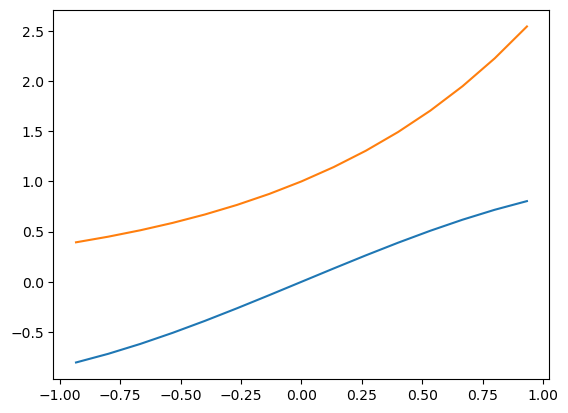

In [7]:
ex.plot(plt, x16, s)
ex.plot(plt, x16, e)
plt.show()

Note that the precision of `x` and `y` does not have to match here. We used `x16` to demonstrate this, even though `s` and `e` have higher precisions.

Just like in `matplotlib.pyplot.plot`, it is possible for you to skip `x` axis data.

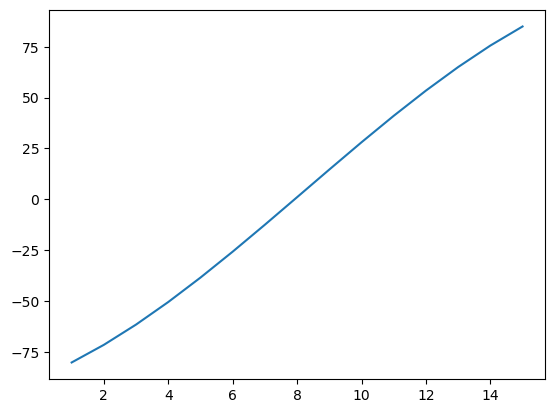

In [8]:
ex.plot(plt, r)

# Differentiation

All spatial discretizations implement differentiation operator `diffop`. The default behaviour of `diffop` in `tensorgrid` spatial discretization is to use Fourier spectral differentiation, which utilises Fast Fourier Transform (FFT) for differentiation. The syntax for differentiation of a function in 1D is:

```Python
    df = ex.diffop(0, 1, f, xrange)
    d2f = ex.diffop(0, 2, f, xrange)
```

Here `f` is a vector with values of a function $f$ on a grid. Then `df` is the `1`st derivative of $f$ in the `0`th direction (i.e. the first and the only coordinate). We also have to specify the `xrange` of the grid on which $f$ is discretised - this is as before, and the default value of `xrange` is `[-1,1]`.

The $k$ th derivative is obtained as `ex.diffop(0, k, f, xrange)`. Later in this notebook you will see how to differentiate a `2d` function in either direction ($x$ or $y$).

**NOTE:**

* Since FFTs are only available for `float32` and higher accuracies, by default `diffop` will fail for `float16` data (i.e. half precision).

* 

NOTE: `expsolve.fourier` assumes that `f` is complex-valued, and so the derivative produced by `diffop` (`df`) is also complex-valued. If the function `f` is real-valued, the result of `diffop` may still have non-zero imaginary component. In such a case, it is sensible to only take the `real` part of the computed derivative. See the following:

We start by creating a grid

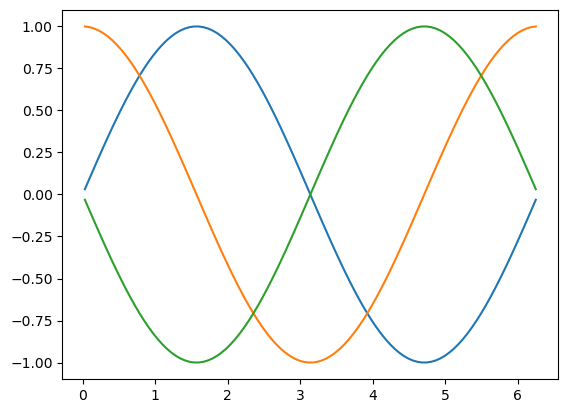

In [9]:
xrange = [0, 2*np.pi]
n = 100
x = ex.grid1d(n, xrange)

s = sin(x)
ds = real(ex.diffop(0,1,s,xrange))
d2s = real(ex.diffop(0,2,s,xrange))

ex.plot(plt, x, s)
ex.plot(plt, x, ds)
ex.plot(plt, x, d2s)
plt.show()

Let's see how accurate the derivative computed in this way is. The true derivative of $\sin(x)$ is $\cos(x)$. 

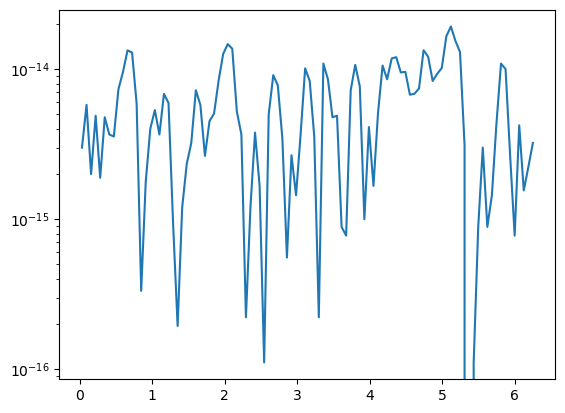

In [10]:
c = cos(x)
ex.semilogy(plt, x, abs(c-ds))
plt.show()

This shows us that the derivative computed in this way is extremely accurate. $\sin$ is a very simple function, of course. 

A more complicated example of a **periodic** function is $\exp(\sin(x))$ whose derivative is $\cos(x) \exp(\sin(x))$.

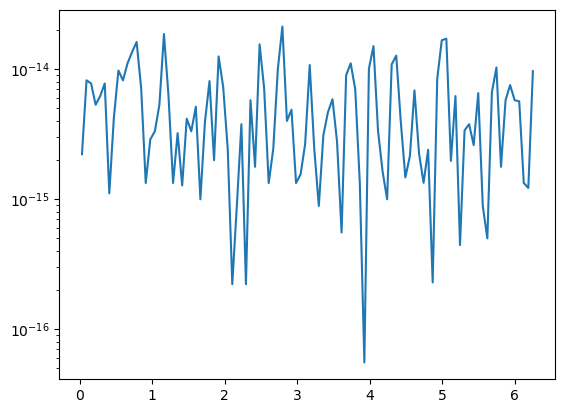

In [11]:
f = exp(sin(x))
df_true = cos(x)*exp(sin(x))
df_numerical = real(ex.diffop(0,1,f,xrange))

plt.semilogy(x.flatten(), abs(df_true-df_numerical).flatten())
plt.show()

Again, the computation looks accurate up to $14$ digits of precision!

## A shorter example with the default `xrange` `[-1,1]`

**NOTE**: differentiation in `expsolve.fourier` is ONLY accurate for smooth periodic functions!

Let's see with an example:

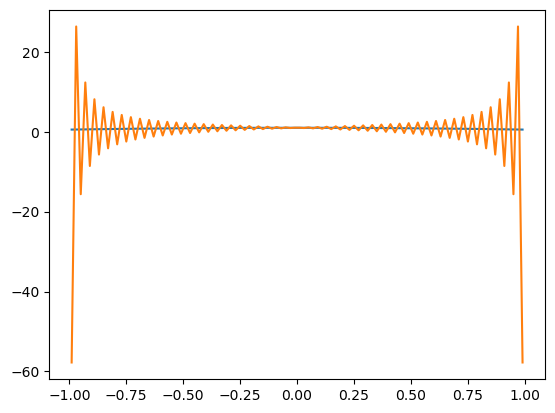

In [12]:
x = ex.grid1d(100)

s = sin(x)
ds_true = cos(x)
ds_numerical = real(ex.diffop(0, 1, s))

ex.plot(plt, x, ds_true)
ex.plot(plt, x, ds_numerical)
plt.show()

The computed derivative is extremely inaccurate since $sin$ is not periodic over $[-1,1]$ (note that we didn't specify `xrange` here, and so it defaults to `[-1,1]`).

Let's contrast this with a function that's periodic on $[-1,1]$:

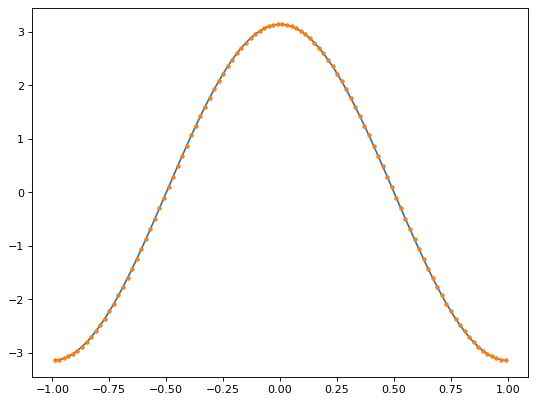

In [13]:
spi = sin(pi*x)
dspi_true = pi*cos(pi*x)
dspi_numerical = real(ex.diffop(0, 1, spi))

plt.figure(figsize=(8, 6), dpi=80)
ex.plot(plt, x, dspi_true)
ex.plot(plt, x, dspi_numerical, marker='.', linestyle=' ')
plt.show()

## Differentiation Matrix

The differentation operator `diffop` is a function that differentiates a function `u`. This is a linear differentiation operator $D(u)$ which is a linear transformation, i.e. $D( a u + b v) = a D(u) + b D(v)$. All linear transformations have a matrix representation, and thus we must have a *matrix* $\mathbf{D}$ such that 

$$ D(u) = \mathbf{D} u$$

The way the differentiation operator `diffop` (i.e. $D$) is implemented, it uses FFT and thus costs $\mathcal{O}\left(n \log n\right)$, which is much more efficient than creating and storing the $n \times n$ matrix $\mathbf{D}$ and computing the matrix-vector product $\mathbf{D} u$, which costs $\mathcal{O}\left(n^2 \right)$.

However, sometimes we might want access to differentiation matrices such as $\mathbf{D}$. `fourier.expsolve` provides the `diffmatrix` function with the following syntax for this purpose:

```Python
    D = ex.diffmatrix(1, n, xrange)
    ds = D @ s
```
where `D` is the first differentiation matrix (i.e. for computing the first derivative), `n` is the size of the matrix ($n \times n$) and `xrange` is as before. When this matrix is multiplied with a vector `s` discretised on a grid on `xrange` with `n` points, it produces the derivative of `s`. 

* For even derivatives, differentiation matrix is real-valued. For odd derivatives it can be complex.
* If `s` is a real valued function, to differentiate it with an odd differentiation matrix, you must convert it to complex using `ex.complex(s)` before computing `D @ s`, and then take the real value of the result.
* If `s` is real, to differentiate it with an even differentiation matrix `D`, it suffices to compute `D @ s`.
* As always, the default value of `xrange` is `[-1,1]`.

Here is an example of computing the second derivative by multiplying with the second differentation matrix:

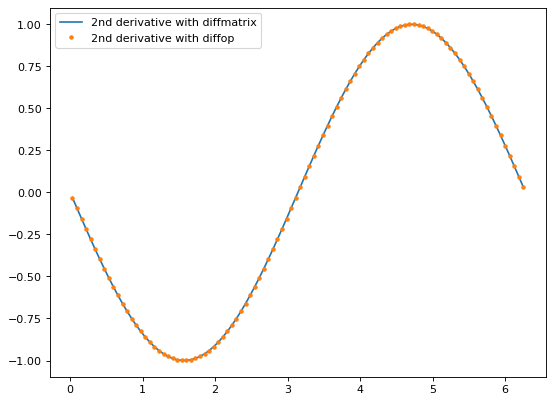

In [15]:
xrange = [0, 2*pi]
n = 100
x = ex.grid1d(n, xrange)
s = sin(x) 
#s = ex.complex(s)                  # needed if using complex diffmatrix

D2 = ex.diffmatrix(2, n, xrange)    # even derivatives are real, so we don't get a complex diffmatrix

D2s = es.linalg.matmul(D2, s)                  # matrix vector product
plt.figure(figsize=(8, 6), dpi=80)
ex.plot(plt, x, D2s)
ex.plot(plt, x, d2s, marker='.',linestyle=' ')
plt.legend(['2nd derivative with diffmatrix', '2nd derivative with diffop'])
plt.show()

Let's see what the difference between the differentiation matrix and the differentiation operator is.

In [17]:
print(max(abs(es.linalg.matmul(D2, s) - d2s.flatten())))

tensor(8.9784e-13, dtype=torch.float64)


## The splitting approach for solving the Schrödinger equation

The splitting approach is to approximate the matrix exponential in 

$$ u(t) = \exp\left(-i t \mathbf{H}\right) u(0) $$

as 

$$ \exp\left(-i h\, \mathbf{H}\right) \quad = \quad \exp\left(i h\, \mathbf{D}_2 - i h\, \texttt{diag}(V) \right) \quad \approx \quad \exp\left(i h\, \mathbf{D}_2\right) \ \exp\left(- i h\, \texttt{diag}(V) \right) $$

which is the 1st order approximation called the Trotter splitting (and h is the time step) or as

$$ \exp\left(-i h\, \mathbf{H}\right) \quad = \quad \exp\left(i h\, \mathbf{D}_2 - i h\, \texttt{diag}(V) \right) \quad \approx \quad \exp\left(- i \frac{h}{2}\, \texttt{diag}(V) \right) \exp\left(i h\, \mathbf{D}_2\right) \ \exp\left(- i \frac{h}{2}\, \texttt{diag}(V) \right) $$

which is the 2nd order approximation called the Strang splitting.

The overall numerical scheme (in the case of the Strang splitting) is:

$$ u_{n+1} = \exp\left(- i \frac{h}{2}\, \texttt{diag}(V) \right) \exp\left(i h\, \mathbf{D}_2\right) \ \exp\left(- i \frac{h}{2}\, \texttt{diag}(V) \right) u_n $$

Splitting is useful because we can compute the exponentials of $\texttt{diag}(V)$ and $\mathbf{D}_2$ much more cheaply separately than we can compute the exponential when they are combined in the full discrestised $\mathbf{H}$. For instance, the computation of the exponential of $\mathbf{H}$ using `matrix_exp` costs $\mathcal{O}\left(n^3\right)$ operations. On the other hand, expoential of $\texttt{diag}(V)$ can be computed in a pointwise way in $\mathcal{O}(n)$ operations, while exponential of $\mathbf{D}_2$ costs us $\mathcal{O}(n \log n)$ operations. The latter is because the Fourier differentiation matrices in `expsolve.fourier` can be diagonalised with the Fourier transform:

$$ \mathbf{D}_k = \mathcal{F}^{-1} \texttt{diag}(s_k) \mathcal{F} $$
where $s_k$ is the symbol of $\mathbf{D}_k$ (in particular, the $j$ th component of $s_k$ is $(s_k)_j = (-i j \pi)^k$). 

In `expsolve.fourier`, the function `diffop` computes the action of `\mathbf{D}_k` on vector `u` as 

$$ \mathbf{D}_k = \mathcal{F}^{-1} \texttt{diag}(s_k) \mathcal{F} u = \texttt{ifft}\left(s_k\ \texttt{fft}(u) \right) $$

in $\mathcal{O}(n \log n)$ operations. This is why `diffop` is preexrred to `diffmatrix` followed by matrix-vector multiplication, which costs $\mathcal{O}(n^2)$ cost and storage.

We can easily see that 

$$ \left(\mathbf{D}_k\right)^n = \mathcal{F}^{-1} \texttt{diag}((s_k)^n) \mathcal{F} $$

With the help of Taylor expanion, we can also seee that exponential of $\mathbf{D}_k$ is

$$ \exp(c \mathbf{D}_k) = \mathcal{F}^{-1} \texttt{diag}(\exp(c s_k)) \mathcal{F} $$

for any $c \in \mathbb{C}$, and it's action on a vector $u$ is computed in $\mathcal{O}(n \log n)$ operations as 

$$ \exp(c \mathbf{D}_k) u= \mathcal{F}^{-1} \texttt{diag}(\exp(c s_k)) \mathcal{F} u = \texttt{ifft}\left( \exp(c s_k) \texttt{fft}(u) \right) .$$

This functionality is implemented in the function `diffopexp`, whose syntax is:


```Python
    eDu = ex.diffopexp(j, k, c, u, xrange) 
```
which computes $\exp(c D_{j,k}) u$, where `u` is the vector of values on a periodic grid defined on the domain `xrange`, $D_{j,k}$ is the $k$ th differentiation operator in the $j$ th direction. 

* Since we are working in 1D here, $j=0$. 
* Since we need 2nd derivative, $k=2$. 